# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [35]:
import pandas as pd
import numpy as np
import nltk
import gensim
import pickle
import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator, Dataset
from string import punctuation

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

SEED = 42
np.random.seed(SEED)

## Data

In [2]:
df = pd.read_csv('imdb_master.csv',  encoding='ISO-8859-1')
df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


Беру старый-добрый токенайзер от NLTK вместо Spacy, потому что не могу поставить Spacy по-человечески, а время поджимает.

In [3]:
def tokenizer(text):
    return [tok for tok in nltk.tokenize.wordpunct_tokenize(text) if tok not in punctuation]

In [4]:
train_df = df[df['type'] == 'train'][['review', 'label']]
test_df = df[df['type'] == 'test'][['review', 'label']]

pd.DataFrame.to_csv(train_df, 'train_df.csv', index=False)
pd.DataFrame.to_csv(test_df, 'test_df.csv', index=False)

In [5]:
classes = {'neg': 0, 'unsup': 1, 'pos': 2}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))

LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

In [6]:
train = TabularDataset('train_df.csv', format='csv', fields=[('review', TEXT), ('label', LABEL)], skip_header=True)
test = TabularDataset('test_df.csv', format='csv', fields=[('review', TEXT), ('label', LABEL)], skip_header=True)

In [7]:
train, valid = train.split(0.7, stratified=True)

Будем использовать эмбеддинги GloVe с dimension=100.

In [8]:
TEXT.build_vocab(train, min_freq=10, vectors="glove.6B.100d")
len(TEXT.vocab.itos)

.vector_cache/glove.6B.zip: 862MB [12:45, 1.13MB/s]                          
100%|█████████▉| 399408/400000 [00:20<00:00, 18490.11it/s]

29466

100%|█████████▉| 399408/400000 [00:40<00:00, 18490.11it/s]

In [9]:
LABEL.build_vocab(train)

## Training

In [10]:
class CustomCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, kernels, glove_vectors, mode):
        super(CustomCNN, self).__init__()
        
        if mode == 'frozen':
            self.embedding = nn.Embedding.from_pretrained(glove_vectors, freeze=True)
        elif mode == 'not_frozen':
            self.embedding = nn.Embedding.from_pretrained(glove_vectors, freeze=False)
        elif mode == 'random':
            self.embedding = nn.Embedding.from_pretrained(nn.init.uniform_(tt.ones((vocab_size, 100))), freeze=False)
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):   
        x = self.embedding(x)
        x = x.transpose(1, 2)   
        concatenated = []
        
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        
        return x

In [11]:
class Trainer:
    def __init__(self, model, train_iterator, test_iterator, valid_iterator):
        self.model = model
        self.train_iterator = train_iterator
        self.test_iterator = test_iterator
        self.valid_iterator = valid_iterator
        
        self.optimizer = optim.Adam(self.model.parameters())
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=5, verbose=True, cooldown=5)
        self.criterion = nn.CrossEntropyLoss()
        
    def train(self, n_epochs):
        min_loss = np.inf
        early_stop = 0
        learning_rate = []
        
        for i in range(n_epochs):
            train_loss = 0
            
            for batch in self.train_iterator:
                self.optimizer.zero_grad()
                y_pred = self.model.forward(batch.review[0])
                loss = self.criterion(y_pred, batch.label)
                train_loss += loss
                loss.backward()
                self.optimizer.step()
                
            train_loss = train_loss / len(self.train_iterator)         
            test_loss = 0
            
            with tt.no_grad():
                for batch in self.test_iterator:
                    test_pred = self.model.forward(batch.review[0])
                    loss = self.criterion(test_pred, batch.label)
                    test_loss += loss
            
            test_loss = test_loss / len(self.test_iterator)           
            self.scheduler.step(test_loss)
            learning_rate.append(self.optimizer.param_groups[0]['lr'])
            
            if test_loss < min_loss:
                min_loss = test_loss
                early_stop = 0
            elif early_stop < 10:
                early_stop += 1
            else:
                break
                
            print('Epoch %s: train loss - %s, test_loss - %s' % (str(i), float(train_loss), float(test_loss)))
                
        return learning_rate
    
    def evaluate(self, mode):
        total_loss = 0
        
        with tt.no_grad():
            for batch in self.valid_iterator:
                y_pred = self.model.forward(batch.review[0])
                loss = self.criterion(y_pred, batch.label)
                total_loss += loss
                
        print('%s loss: %s' % (mode, float(total_loss / len(self.valid_iterator))))
                    
        return float(total_loss / len(self.valid_iterator))

In [12]:
tt.cuda.empty_cache()
batch_size = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train, valid, test), 
                                                                       batch_sizes=(batch_size, batch_size, batch_size),
                                                                       shuffle=True,
                                                                       sort_key=lambda x: len(x.review))

### 1. Pretrained word embeddings with frozen weights

In [13]:
fr_model = CustomCNN(vocab_size=len(TEXT.vocab.vectors),
                     embed_size=100,
                     hidden_size=128,
                     kernels=[2,3,4,5],
                     glove_vectors=TEXT.vocab.vectors,
                     mode='frozen')

trainer = Trainer(fr_model, train_iterator, test_iterator, valid_iterator)
fr_lr = trainer.train(10)

Epoch 0: train loss - 0.8317148685455322, test_loss - 1.7207719087600708
Epoch 1: train loss - 0.8152943253517151, test_loss - 1.5500537157058716
Epoch 2: train loss - 0.8140267133712769, test_loss - 1.4663772583007812
Epoch 3: train loss - 0.8124980926513672, test_loss - 1.5018937587738037
Epoch 4: train loss - 0.8121437430381775, test_loss - 1.626752495765686
Epoch 5: train loss - 0.8115540742874146, test_loss - 1.366530179977417
Epoch 6: train loss - 0.810383677482605, test_loss - 1.4011476039886475
Epoch 7: train loss - 0.8105039596557617, test_loss - 1.7180227041244507
Epoch 8: train loss - 0.810346245765686, test_loss - 2.0324437618255615
Epoch 9: train loss - 0.8090224266052246, test_loss - 1.427108883857727


In [14]:
fr_val = trainer.evaluate('First "frosen" mode')

First "frosen" mode loss: 1.0068987607955933


### 2. Initializing from pretrained weights

In [15]:
nfr_model = CustomCNN(vocab_size=len(TEXT.vocab.vectors),
                   embed_size=100,
                   hidden_size=128,
                   kernels=[2,3,4,5],
                   glove_vectors=TEXT.vocab.vectors,
                   mode='not_frozen')

trainer = Trainer(nfr_model, train_iterator, test_iterator, valid_iterator)
nfr_lr = trainer.train(10)

Epoch 0: train loss - 0.7909947037696838, test_loss - 1.4683773517608643
Epoch 1: train loss - 0.6473090648651123, test_loss - 2.0606770515441895
Epoch 2: train loss - 0.5150255560874939, test_loss - 3.6005849838256836
Epoch 3: train loss - 0.42406898736953735, test_loss - 6.300321102142334
Epoch 4: train loss - 0.3652002811431885, test_loss - 9.373689651489258
Epoch 5: train loss - 0.3158486783504486, test_loss - 9.184029579162598
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch 6: train loss - 0.2812400460243225, test_loss - 9.677691459655762
Epoch 7: train loss - 0.19202645123004913, test_loss - 12.784418106079102
Epoch 8: train loss - 0.17434649169445038, test_loss - 14.928235054016113
Epoch 9: train loss - 0.1636325716972351, test_loss - 17.006771087646484


In [16]:
nfr_val = trainer.evaluate('Second "not frozen" mode')

Second "not frozen" mode loss: 5.203453540802002


### 3. Random initialization

In [17]:
random_model = CustomCNN(vocab_size=len(TEXT.vocab.vectors),
                   embed_size=100,
                   hidden_size=128,
                   kernels=[2,3,4,5],
                   glove_vectors=TEXT.vocab.vectors,
                   mode='random')

trainer = Trainer(random_model, train_iterator, test_iterator, valid_iterator)
random_lr = trainer.train(10)

Epoch 0: train loss - 0.8757027387619019, test_loss - 1.6639958620071411
Epoch 1: train loss - 0.7856147885322571, test_loss - 1.5791207551956177
Epoch 2: train loss - 0.7073385715484619, test_loss - 1.495008111000061
Epoch 3: train loss - 0.641311764717102, test_loss - 2.036668300628662
Epoch 4: train loss - 0.5635643601417542, test_loss - 2.8929102420806885
Epoch 5: train loss - 0.48698312044143677, test_loss - 4.522313594818115
Epoch 6: train loss - 0.4256249666213989, test_loss - 4.4446210861206055
Epoch 7: train loss - 0.3783968687057495, test_loss - 6.259246826171875
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch 8: train loss - 0.34115326404571533, test_loss - 7.4834794998168945
Epoch 9: train loss - 0.255906879901886, test_loss - 9.596759796142578


In [18]:
random_val = trainer.evaluate('Third "random" mode')

Third "random" mode loss: 3.156709909439087


## Visual information

### 1. Learning rate plots

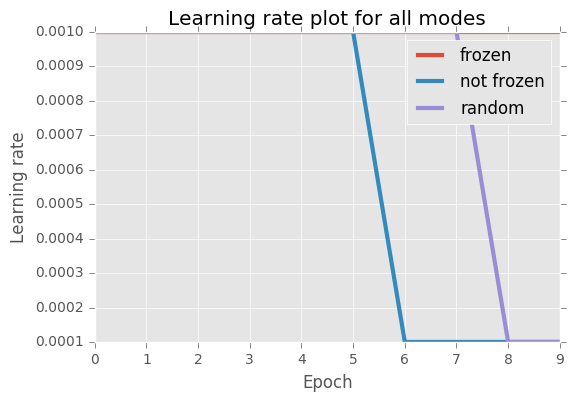

In [39]:
plt.plot(range(0, len(fr_lr)), fr_lr, label='frozen', linewidth=3)
plt.plot(range(0, len(nfr_lr)), nfr_lr, label='not frozen', linewidth=3)
plt.plot(range(0, len(random_lr)), random_lr, label='random', linewidth=3)

plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate plot for all modes')

### 2. Validation curves

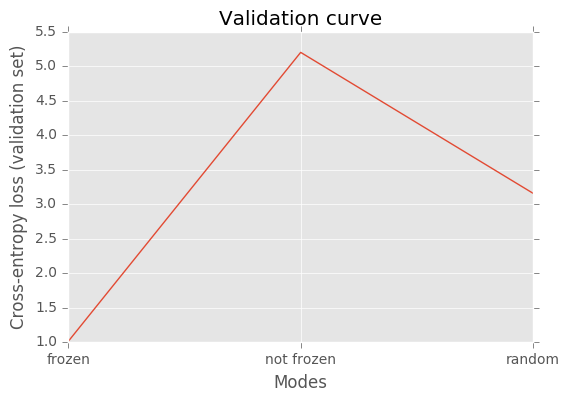

In [33]:
plt.plot([2, 3, 4], [fr_val, nfr_val, random_val])
plt.xticks([2, 3, 4], ['frozen', 'not frozen', 'random'])
plt.xlabel('Modes')
plt.ylabel('Cross-entropy loss (validation set)')
plt.title('Validation curve')